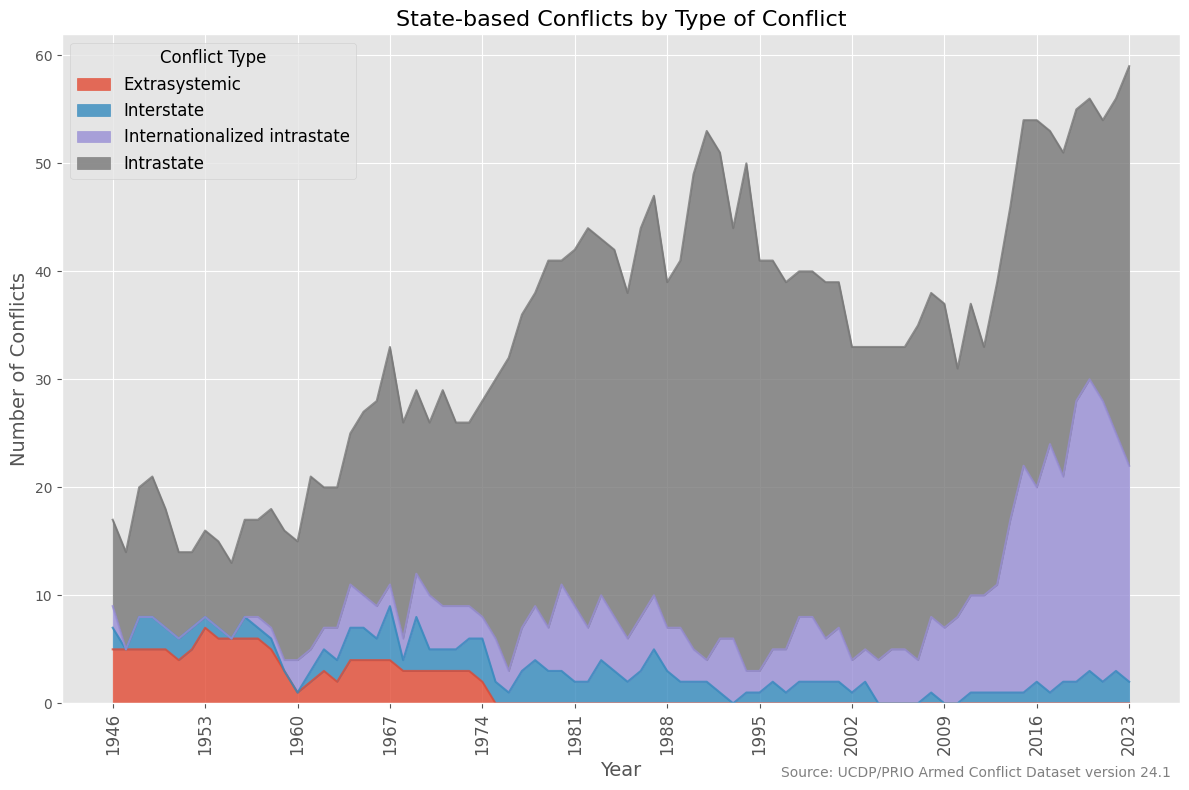

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# ----------------------------
# Step 1: Retrieve Data from the API
# ----------------------------
base_url = "https://ucdpapi.pcr.uu.se/api/ucdpprioconflict/24.1"
pagesize = 1000  
page = 0
all_conflicts = []

while True:
    params = {
        'pagesize': pagesize,
        'page': page
    }
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    data = response.json()
    
    results = data.get("Result", [])
    if not results:
        break
    
    all_conflicts.extend(results)
    page += 1
    if page >= data.get("TotalPages", 0):
        break

df = pd.DataFrame(all_conflicts)

# ----------------------------
# Step 2: Aggregate the Data
# ----------------------------

df['type_of_conflict'] = pd.to_numeric(df['type_of_conflict'], errors='coerce')

yearly_conflict_counts = (
    df.groupby(['year', 'type_of_conflict'])['conflict_id']
      .nunique()
      .reset_index(name='unique_conflict_count')
)
yearly_conflict_counts.sort_values(by=['year', 'type_of_conflict'], inplace=True)

# ----------------------------
# Step 3: Map Numeric Conflict Types to Descriptive Labels
# ----------------------------
conflict_type_labels = {
    1: "Extrasystemic",
    2: "Interstate",
    3: "Intrastate",
    4: "Internationalized intrastate"
}

yearly_conflict_counts['conflict_type_label'] = yearly_conflict_counts['type_of_conflict'].map(conflict_type_labels)

# ----------------------------
# Step 4: Create a Pivot Table for the Area Chart
# ----------------------------
pivot_df = yearly_conflict_counts.pivot_table(
    index='year', 
    columns='conflict_type_label', 
    values='unique_conflict_count',
    aggfunc='sum'
).fillna(0)

pivot_df = pivot_df.astype(float)
pivot_df.sort_index(inplace=True)

desired_order = ["Extrasystemic", "Interstate", "Internationalized intrastate", "Intrastate"]
pivot_df = pivot_df.reindex(columns=desired_order)

# Ensure the index (year) is numeric
pivot_df.index = pivot_df.index.astype(int)

# ----------------------------
# Step 5: Plot the Stacked Area Chart
# ----------------------------
fig, ax = plt.subplots(figsize=(12, 8))

pivot_df.plot(kind='area', stacked=True, alpha=0.8, ax=ax)

ax.set_title("State-based Conflicts by Type of Conflict", fontsize=16)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Conflicts", fontsize=14)

ax.legend(title="Conflict Type", loc='upper left', fontsize=12, title_fontsize=12, frameon=True, framealpha=0.8)

# Set x-ticks: tick every 7 years (1946 to 2023)
years = pivot_df.index
ax.set_xticks(years[::7])
ax.set_xticklabels(years[::7], rotation='vertical', fontsize=12)

fig.text(0.98, 0.02, "Source: UCDP/PRIO Armed Conflict Dataset version 24.1", 
         ha="right", va="bottom", fontsize=10, color="gray")

plt.tight_layout()
plt.show()